Original dataset shape: (178, 13)
Original dataset preview:
   alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

  

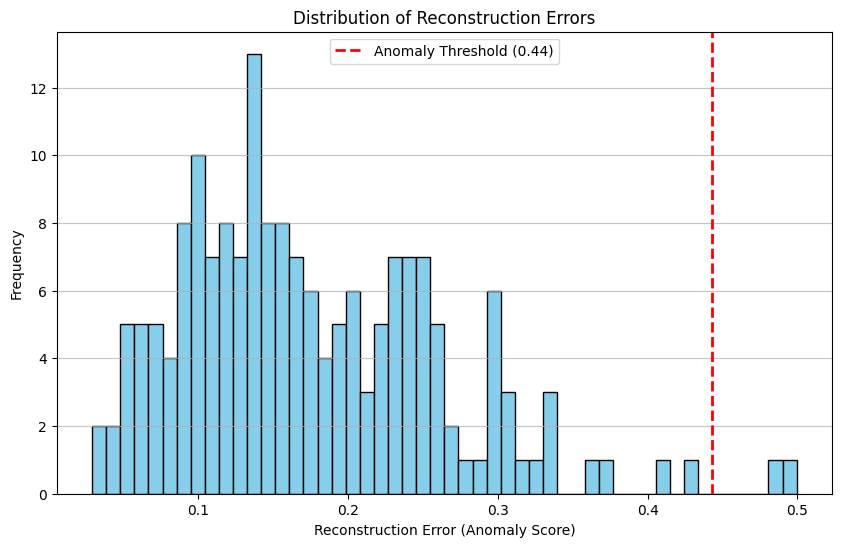

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# ---
# Principal Component Analysis (PCA) for Anomaly Detection
# ---
#
# When to use this technique:
# PCA for anomaly detection is best suited for high-dimensional datasets where you suspect
# anomalies are not just extreme values in a single feature, but rather unusual
# combinations of values across multiple features. It's an unsupervised method,
# meaning it doesn't require pre-labeled data (i.e., you don't need to know
# which data points are anomalies beforehand).
#
# Requirements for the data:
# 1.  Numerical Data: The input data must be numerical. Categorical features should be
#     encoded or removed.
# 2.  Scaling: PCA is sensitive to the scale of the features. It's crucial to
#     scale the data (e.g., using StandardScaler) before applying PCA. This ensures
#     that features with larger variances don't dominate the principal components.
# 3.  Linearity Assumption: PCA is a linear method, so it works best when the
#     underlying relationships in the data are linear.

# 1. Load a sample dataset
# We'll use the scikit-learn wine dataset, which has multiple numerical features.
wine = load_wine()
X = pd.DataFrame(wine.data, columns=wine.feature_names)
print("Original dataset shape:", X.shape)
print("Original dataset preview:")
print(X.head())
print("-" * 30)

# 2. Preprocess the data
# We select all features and scale them using StandardScaler.
features = X.columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=features)

print("Scaled dataset preview:")
print(X_scaled.head())
print("-" * 30)


# 3. Apply Principal Component Analysis (PCA)
# We apply PCA to reduce the dimensionality of the data.
# By setting n_components to a value between 0 and 1 (e.g., 0.95), we instruct
# PCA to retain the number of components that explain 95% of the total variance.
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print(f"Original number of features: {X_scaled.shape[1]}")
print(f"Reduced number of features (Principal Components): {pca.n_components_}")
print("-" * 30)


# 4. Calculate the Reconstruction Error
# The core idea is to transform the data back from the PCA-reduced space to the
# original feature space. The difference between the original and the reconstructed
# data is the "reconstruction error". Anomalies will have a higher error because
# they are not well-represented by the principal components derived from the normal data.

X_reconstructed = pca.inverse_transform(X_pca)
reconstruction_error = np.sqrt(np.mean(np.square(X_scaled - X_reconstructed), axis=1))

# Add the error as a new column to the original scaled dataframe
X_scaled['reconstruction_error'] = reconstruction_error


# 5. Identify Anomalies
# We can define a threshold for the reconstruction error. Any data point with an
# error above this threshold is flagged as an anomaly. A common approach is to use
# a quantile of the errors. For example, we can flag the top 1% of errors as anomalies.

anomaly_threshold = X_scaled['reconstruction_error'].quantile(0.99)
outliers = X[X_scaled['reconstruction_error'] > anomaly_threshold]

# Create the final DataFrame of outliers
# We use the original, unscaled data for interpretability and add the calculated score.
outliers_with_scores = X.loc[outliers.index].copy()
outliers_with_scores['anomaly_score'] = X_scaled.loc[outliers.index, 'reconstruction_error']


# 6. Show the results
print(f"Anomaly Threshold (99th percentile): {anomaly_threshold:.4f}")
print(f"Number of identified outliers: {len(outliers_with_scores)}")
print("\nIdentified Outliers (original values) with their Anomaly Score:")
print(outliers_with_scores.head())


# 7. Visualize the results
# A histogram of the reconstruction error can be very insightful.
plt.figure(figsize=(10, 6))
plt.hist(X_scaled['reconstruction_error'], bins=50, color='skyblue', edgecolor='black')
plt.axvline(anomaly_threshold, color='r', linestyle='dashed', linewidth=2, label=f'Anomaly Threshold ({anomaly_threshold:.2f})')
plt.title('Distribution of Reconstruction Errors')
plt.xlabel('Reconstruction Error (Anomaly Score)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()

